In [60]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 3.2MB/s 
     |████████████████████████████████| 9.5MB 21.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [12]:
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
df = pd.read_csv('/content/drive/MyDrive/Solar energy prediction - Project/Datasets/Out/full.csv', parse_dates=True, index_col=0)

In [10]:
df.head()

,Solaire (MW),air_temp,precip_depth_per_hour,station_pressure_rate,Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2)
2017-01-01 01:00:00,0,-37.0,0.0,10180.0,4.53,0.00
2017-01-01 04:00:00,0,-40.0,0.0,10162.0,5.30,0.00
2017-01-01 07:00:00,0,-41.0,0.0,10144.0,4.92,0.00
2017-01-01 10:00:00,15,-30.0,0.0,10137.0,4.71,7.09
2017-01-01 13:00:00,22,-10.0,0.0,10115.0,4.30,84.24


# **Define a error metrics function**
RMSE, R2, MAE and MAPE error metrics

In [11]:
def error_metrics(y_pred, y_truth, model_name = None):
    """
    Printing error metrics like RMSE (root mean square error), R2 score, 
    MAE (mean absolute error), MAPE (mean absolute % error). 
    
    y_pred: predicted values of y using the model model_name
    y_truth: observed values of y
    model_name: name of the model used for predictions
    
    The function will print the RMSE, R2, MAE and MAPE error metrics for the model_name
    """
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
        
    print('\nError metrics for model {}'.format(model_name))
    
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)
    
    # Explained variance score: 1 is perfect prediction

    R2 = r2_score(y_truth, y_pred)
    print('Variance score: %.2f' % R2 )

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)

    MAPE = (np.mean(np.abs((y_truth - y_pred) / y_truth)) * 100)
    print('Mean Absolute Percentage Error: %.2f %%' % MAPE)

In [19]:
fig = go.Figure([go.Scatter(x=df.index, y=df['Solaire (MW)'])])
fig.update_layout(
    title="Time Series of Solar Production (in MW) Ile-de-France",
    xaxis_title="Time",
    yaxis_title="Solar production (MW)",
)
fig.show()

**Decompose the time series to identify its multiple**

In [14]:
def plot_timeseries(ts, title = 'og', opacity = 1):
    """
    Plot plotly time series of any given timeseries ts
    """
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = ts.index, y = ts.values, name = "observed",
                         line_color = 'lightslategrey', opacity = opacity))

    fig.update_layout(title_text = title,
                  xaxis_rangeslider_visible = True)
    fig.show()

In [15]:
from statsmodels.graphics import tsaplots

2017-01-01 01:00:00   -67.432871
2017-01-01 04:00:00   -67.434869
2017-01-01 07:00:00   -67.102734
2017-01-01 10:00:00   -50.103305
2017-01-01 13:00:00   -40.103305
Name: Solaire (MW), dtype: float64


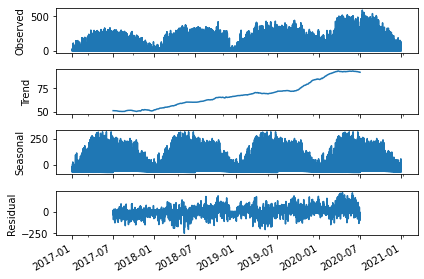

In [17]:
import statsmodels.api as sm

# Run seasonal decompose
decomp = sm.tsa.seasonal_decompose(df['Solaire (MW)'], freq=8*365) # capturing the yearly seasonal component;
# i.e. for example every July the energy production is high and then it gets lower during the winter months. 
#...So, a periodicity of 24hours*365 was used here.

print(decomp.seasonal.head()) # checking the seasonal component
_ = decomp.plot()

In [18]:
# Plotting the seasonal coponent only
plot_timeseries(decomp.seasonal, title = 'Seasonal component')

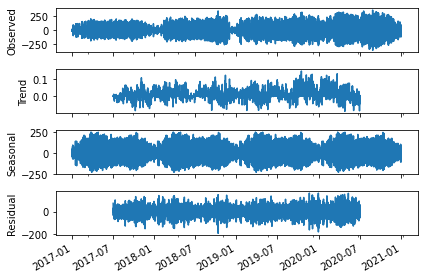

In [22]:
# Differencing the data once
decomp_diff1 = sm.tsa.seasonal_decompose(df['Solaire (MW)'].diff().dropna(), freq=8*365) 
_ = decomp_diff1.plot()

- Comparing the above differenced plot with the previous original data plot we can see the trend was removed by differencing just once and also the effect of seasonality was also reduced.

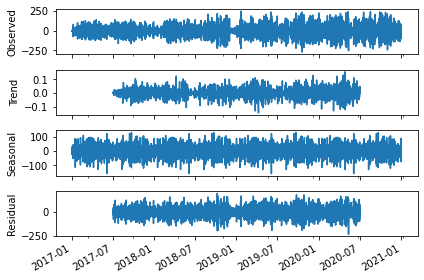

In [23]:
# Differencing the data with periodicity of 24 hours in addition to the original single differencing
decomp_diff24 = sm.tsa.seasonal_decompose(df['Solaire (MW)'].diff().dropna().diff(8).dropna(), freq=8*365) 
_ = decomp_diff24.plot()

- Differencing the dataset once and then with the period of 24 hours (8*3h) further diminishes any trend and seasonality effects and seems to render the dataset stationary.

# **Testing for stationarity**
- Using Dicky Fuller test as well as KPSS

In [24]:
from statsmodels.tsa.stattools import adfuller, kpss

In [25]:
def run_adfuller(ts):
  result = adfuller(ts, autolag='AIC')
  print(f'ADF Statistic: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'num lags: {result[2]}')
  for key, value in result[4].items():
      print('Critial Values:')
      print(f'   {key}, {value}\n')

def run_kpss(ts):
  statistic, p_value, n_lags, critical_values = kpss(ts)
  # Format Output
  print(f'KPSS Statistic: {statistic}')
  print(f'p-value: {p_value}')
  print(f'num lags: {n_lags}')
  print('Critial Values:')
  for key, value in critical_values.items():
      print(f'   {key} : {value}')
  print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary\n')

In [27]:
print("for no differencing\n")
run_adfuller(df['Solaire (MW)'])
run_kpss(df['Solaire (MW)'])
print("\nfor single differencing\n")
run_adfuller(df['Solaire (MW)'].diff().dropna())
run_kpss(df['Solaire (MW)'].diff().dropna())
print("\nfor differenced data set over lags 24 after single differencing\n")
run_adfuller(df['Solaire (MW)'].diff().dropna().diff(8).dropna())
run_kpss(df['Solaire (MW)'].diff().dropna().diff(8).dropna())

for no differencing

ADF Statistic: -4.9554606809449595
p-value: 2.716730589964139e-05
num lags: 40
Critial Values:
   1%, -3.4309115816789784

Critial Values:
   5%, -2.8617881895614543

Critial Values:
   10%, -2.566902106222889

KPSS Statistic: 3.9813526850938064
p-value: 0.01
num lags: 40
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


for single differencing



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



ADF Statistic: -27.250871777829488
p-value: 0.0
num lags: 40
Critial Values:
   1%, -3.430911629910606

Critial Values:
   5%, -2.861788210875281

Critial Values:
   10%, -2.566902117568152

KPSS Statistic: 0.005688934506087456
p-value: 0.1
num lags: 40
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


for differenced data set over lags 24 after single differencing



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



ADF Statistic: -34.699909749185665
p-value: 0.0
num lags: 39
Critial Values:
   1%, -3.430911967764111

Critial Values:
   5%, -2.8617883601746312

Critial Values:
   10%, -2.5669021970395876

KPSS Statistic: 0.001779835484477009
p-value: 0.1
num lags: 40
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



Based on the p-values of ADF tests, it seems that even our original dataset is stationary. But with further KPSS test, we can see that the original dataset was not stationary (as evident from the decomposed plot). However, the single differencing model is already stationary based on both tests. Thus we can use the single differencing model to remove the trend and fit our model on detrended data.

# **ACF and PACF graphs**

The correlation of the time series observations calculated with values of the same series at previous times, is called a serial correlation, or an autocorrelation (ACF). It is used to determine the moving average (MA or q) term of the ARIMA(p,d,q) models.

A partial autocorrelation (PACF) is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed. It is used to determine the auto regression (AR or p) term of the ARIMA(p,d,q) models.

In [28]:
def acf_pacf_plots(ts, lags, figsize = (12,8)):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = figsize)
    
    # Plot the ACF of ts
    _ = plot_acf(ts, lags = lags, zero = False, ax = ax1, alpha = 0.05)

    # Plot the PACF of ts
    _ = plot_pacf(ts, lags = lags, zero = False, ax = ax2, alpha = 0.05)

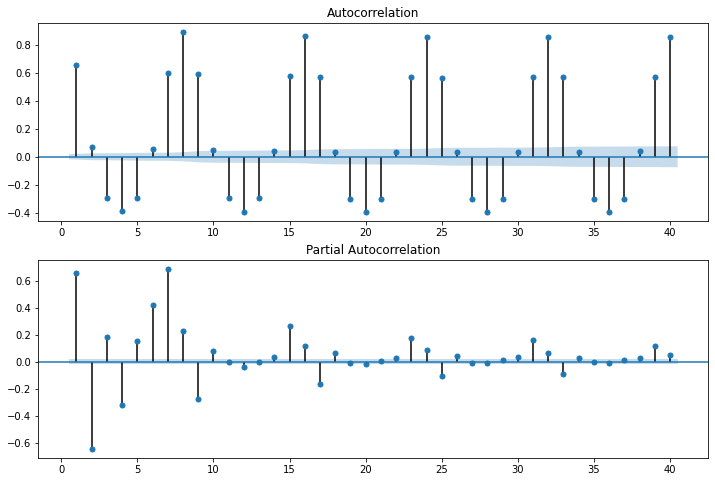

In [29]:
dfacf = df['Solaire (MW)']
lags = 40

acf_pacf_plots(dfacf, lags = lags, figsize = (12,8))

The seasonal period of 24 hours can be easily observed

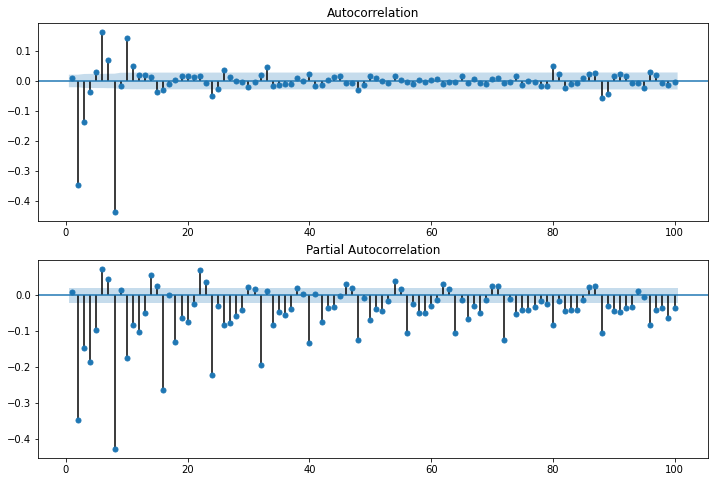

In [ ]:
# Differencing the data this time to remove the trend and seasonality
dfacf = dfacf.diff().dropna() 
dfacf = dfacf.diff(8).dropna() 
dfacf = dfacf.diff(8*365).dropna() 
lags=100
acf_pacf_plots(dfacf, lags = lags, figsize = (12,8))

Even after differencing and seasonal differencing the data, the ACF and PACF plots are not very informative.

This is a common pitfall of the ACF, PACF plots and SARIMAX models. They cannot handle multiple seasonality. And our energy production dataset has multiple seasonalities - daily (24 hours), yearly (24*365). We'll have to deal with the multiple seasonality separately to be able to use SARIMAX model on our energy production time series

# **Deal with multiple seasonality**
We will use Facebook's [Prophet model](https://facebook.github.io/prophet/docs/quick_start.html#python-api), as well as SARIMAX model with Fourier terms, for more info see [link](https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a)

In [42]:
#split training and testing set
split_date = '2020-09-01'
train = df.loc[df.index < split_date].copy()
test = df.loc[df.index >= split_date].copy()

## **Prophet module**

In [31]:
from fbprophet import Prophet

In [35]:
# preparing data for Prophet
def data_prophet(train, test):
  train = train.reset_index().rename(columns = {'Solaire (MW)':'y', 'index':'ds'})
  test  = test.reset_index().rename(columns = {'Solaire (MW)':'y', 'index':'ds'})
  return train, test

In [36]:
train_prophet, test_prophet = data_prophet(train, test)

In [37]:
test_prophet.tail()

,ds,y,air_temp,precip_depth_per_hour,station_pressure_rate,Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2)
971,2020-12-31 10:00:00,30,36.0,0.0,9935.0,7.30,42.83
972,2020-12-31 13:00:00,51,49.0,0.0,9937.0,7.46,94.23
973,2020-12-31 16:00:00,5,51.0,0.0,9954.0,7.51,96.84
974,2020-12-31 19:00:00,0,40.0,0.0,9967.0,7.45,34.93
975,2020-12-31 22:00:00,0,25.0,0.0,9978.0,7.45,0.00


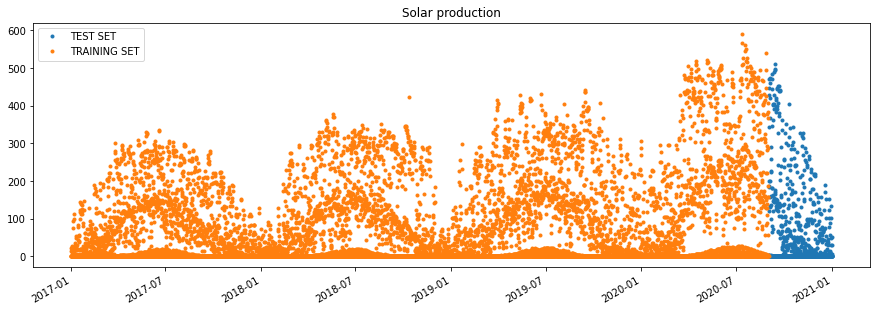

In [44]:
test[['Solaire (MW)']] \
    .rename(columns={'Solaire (MW)': 'TEST SET'}) \
    .join(train[['Solaire (MW)']].rename(columns={'Solaire (MW)': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Solar production', style='.')
plt.show()

In [77]:
# Initiating fbprophet model; set the uncertainty interval to 95% (the Prophet default is 80%)
prop = Prophet(interval_width = 0.95)

In [78]:
prop.fit(train_prophet)

In [47]:
forecast = prop.predict(pd.concat([train_prophet,test_prophet]))

In [48]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
11683,2020-12-31 10:00:00,139.035173,81.710085,310.774644,135.911547,142.020762,53.845868,53.845868,53.845868,102.203871,102.203871,102.203871,-1.131908,-1.131908,-1.131908,-47.226095,-47.226095,-47.226095,0.0,0.0,0.0,192.881041
11684,2020-12-31 13:00:00,139.055144,122.237172,354.209863,135.927258,142.046516,97.563237,97.563237,97.563237,146.215812,146.215812,146.215812,-1.460175,-1.460175,-1.460175,-47.192401,-47.192401,-47.192401,0.0,0.0,0.0,236.618382
11685,2020-12-31 16:00:00,139.075116,22.975210,255.143380,135.942969,142.072271,-6.327980,-6.327980,-6.327980,42.563723,42.563723,42.563723,-1.732613,-1.732613,-1.732613,-47.159091,-47.159091,-47.159091,0.0,0.0,0.0,132.747136
11686,2020-12-31 19:00:00,139.095087,-65.720118,152.358889,135.958679,142.098025,-98.920890,-98.920890,-98.920890,-49.882400,-49.882400,-49.882400,-1.912318,-1.912318,-1.912318,-47.126172,-47.126172,-47.126172,0.0,0.0,0.0,40.174197
11687,2020-12-31 22:00:00,139.115058,-92.397344,132.477892,135.974390,142.123780,-120.975618,-120.975618,-120.975618,-71.912954,-71.912954,-71.912954,-1.969011,-1.969011,-1.969011,-47.093652,-47.093652,-47.093652,0.0,0.0,0.0,18.139441


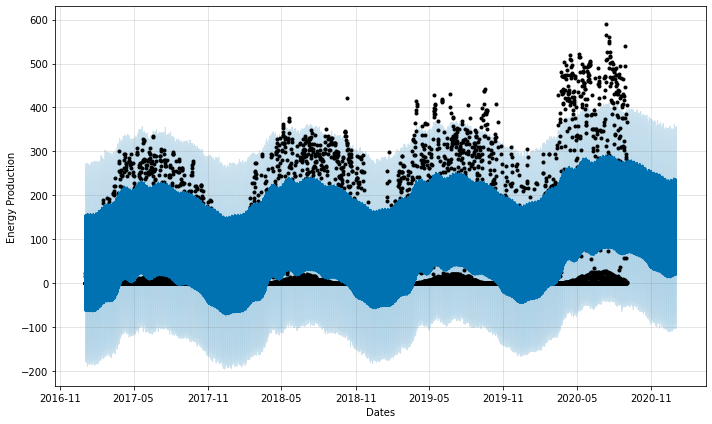

In [49]:
#pd.plotting.register_matplotlib_converters()
_ = prop.plot(forecast, uncertainty = True, xlabel = 'Dates', ylabel = 'Energy Production', )

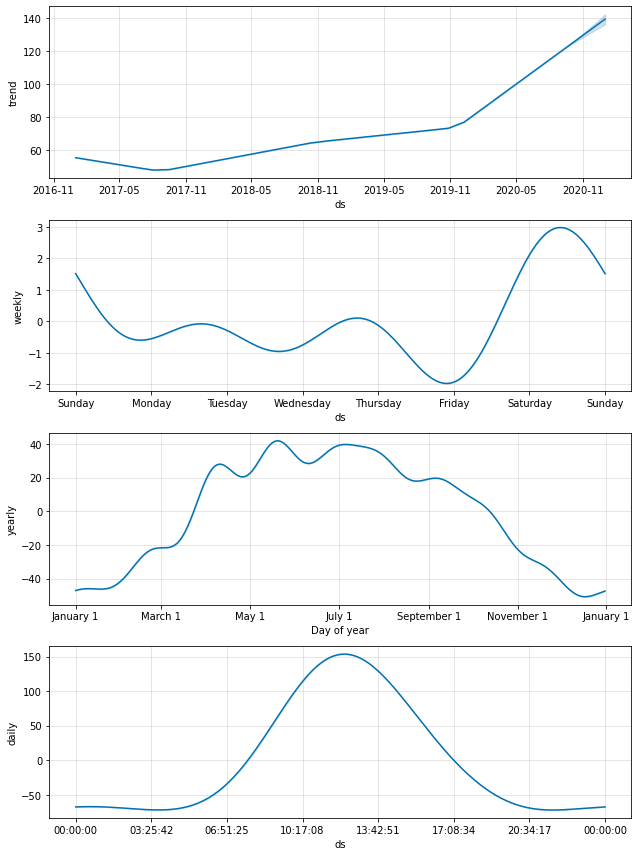

In [50]:
# Plotting the components of the results
_ = prop.plot_components(forecast)

We can see that the multiple seasonalities were captured very well by the Prophet model.

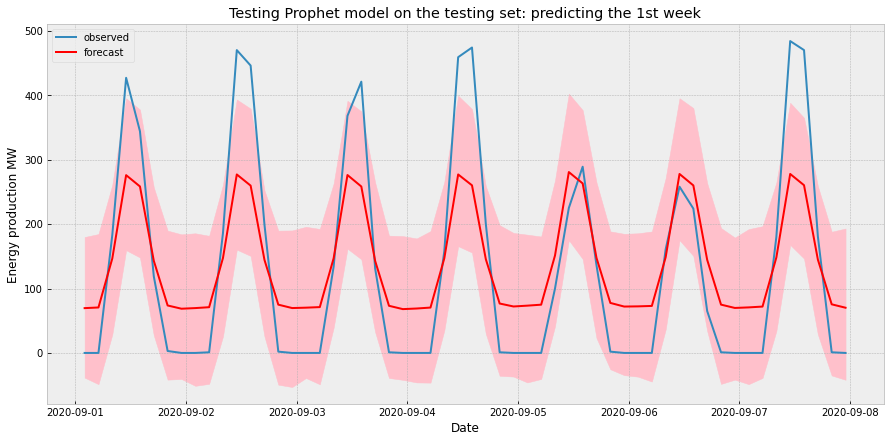

In [52]:
y_actual = test.iloc[:8*7]['Solaire (MW)']

pred2 = prop.predict(test_prophet).iloc[:8*7]
pred2.set_index(keys='ds',inplace=True)
lower_limits = pred2.loc[:,'yhat_lower']
upper_limits = pred2.loc[:,'yhat_upper']

plt.style.use('bmh')
# plot the predictions
plt.figure(figsize = (15,7))
_ = plt.plot(y_actual.index, y_actual, label='observed')

# plot your mean predictions
_ = plt.plot(pred2.index, pred2['yhat'], color='r', label='forecast')

# shade the area between your confidence limits
_ = plt.fill_between(lower_limits.index,lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing Prophet model on the testing set: predicting the 1st week')

Cross validation on the training set: 

It needs an inital, period and horizon as inputs. $Initial$ is the training sub set to be used for training the model on, $period$ is the number of time frames the data should be shifted forward by for extending the training subset and $horizon$ is the window of forecast.

In [53]:
from fbprophet.diagnostics import cross_validation

In [54]:
# Cross validating on the training set with an initial training period of 7141*3h and a forecast horizon of 8*3h*7 hours (1 week ahead)
df_cv = cross_validation(prop, initial='730 days', period= '60 days', horizon = '7 days')
df_cv.head(3)

INFO:fbprophet:Making 11 forecasts with cutoffs between 2019-01-02 23:00:00 and 2020-08-24 23:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-03 01:00:00,-40.177219,-131.734570,52.248320,0,2019-01-02 23:00:00
1,2019-01-03 04:00:00,-43.600850,-140.167913,44.892050,0,2019-01-02 23:00:00
2,2019-01-03 07:00:00,-11.822018,-104.149378,79.286039,2,2019-01-02 23:00:00


In [55]:
error_metrics(df_cv['yhat'], df_cv['y'], 'FB Prophet with auto seasonality 1 week ahead')


Error metrics for model FB Prophet with auto seasonality 1 week ahead
RMSE or Root mean squared error: 60.43
Variance score: 0.70
Mean Absolute Error: 47.27
Mean Absolute Percentage Error: inf %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning:

divide by zero encountered in true_divide



In [56]:
error_metrics(forecast.iloc[-len(test_prophet['y']):, ]['yhat'], test_prophet['y'], 
              'FB Prophet with auto seasonality')


Error metrics for model FB Prophet with auto seasonality
RMSE or Root mean squared error: 85.46
Variance score: 0.35
Mean Absolute Error: 70.43
Mean Absolute Percentage Error: inf %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning:

divide by zero encountered in true_divide



## **SARIMAX model**

In [57]:
def add_fourier_terms(df, year_k, day_k):
    """
    df: dataframe to add the fourier terms to 
    year_k: the number of Fourier terms the year period should have. Thus the model will be fit on 2*year_k terms (1 term for 
    sine and 1 for cosine)
    day_k:same as year_k but for daily periods
    """
    
    for k in range(1, year_k+1):
        # year has a period of 365.25 including the leap year
        df['year_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofyear/365.25) 
        df['year_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofyear/365.25)

    for k in range(1, day_k+1):
        
        # day has period of 24
        df['hour_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.hour/24)
        df['hour_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.hour/24)

In [58]:
df_fourier = df.copy(deep=True)
add_fourier_terms(df_fourier, year_k= 5, day_k=5)

In [59]:
df_fourier.columns

Index(['Solaire (MW)', 'air_temp', 'precip_depth_per_hour',
       'station_pressure_rate', 'Vitesse du vent à 100m (m/s)',
       'Rayonnement solaire global (W/m2)', 'year_sin1', 'year_cos1',
       'year_sin2', 'year_cos2', 'year_sin3', 'year_cos3', 'year_sin4',
       'year_cos4', 'year_sin5', 'year_cos5', 'hour_sin1', 'hour_cos1',
       'hour_sin2', 'hour_cos2', 'hour_sin3', 'hour_cos3', 'hour_sin4',
       'hour_cos4', 'hour_sin5', 'hour_cos5'],
      dtype='object')

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [62]:
X_train_fourier = df_fourier.drop(columns='Solaire (MW)').loc[df_fourier.index <= split_date].copy()
y_train_fourier = df_fourier['Solaire (MW)'].loc[df_fourier.index <= split_date].copy()
X_test_fourier = df_fourier.drop(columns='Solaire (MW)').loc[df_fourier.index > split_date].copy()
y_test_fourier = df_fourier['Solaire (MW)'].loc[df_fourier.index > split_date].copy()

In [ ]:
fourier = pm.auto_arima(y_train_fourier, #data 
                        d=1, # non-seasonal difference order 
                        start_p=0, # initial guess for p 
                        start_q=0, # initial guess for q 
                        max_p=3, # max value of p to test 
                        max_q=3, # max value of q to test
                        exogenous= X_train_fourier, #including the exogenous variables
                        seasonal=True, # is the time series seasonal 
                        m=8, # the seasonal period 
                        D=None, # seasonal difference order 
                        start_P=1, # initial guess for P 
                        start_Q=1, # initial guess for Q 
                        max_P=1, # max value of P to test 
                        max_Q=1, # max value of Q to test 
                        information_criterion='aic', # used to select best model 
                        trace=True, # print results whilst training 
                        error_action='ignore', # ignore orders that don't work 
                        stepwise=True # apply intelligent order search 
                        ) 
print(fourier.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[8] intercept   : AIC=107078.892, Time=150.36 sec
 ARIMA(0,1,0)(0,0,0)[8] intercept   : AIC=114495.230, Time=2.06 sec
 ARIMA(1,1,0)(1,0,0)[8] intercept   : AIC=109256.415, Time=86.61 sec
 ARIMA(0,1,1)(0,0,1)[8] intercept   : AIC=110724.669, Time=43.50 sec
 ARIMA(0,1,0)(0,0,0)[8]             : AIC=114493.232, Time=21.95 sec
 ARIMA(0,1,0)(0,0,1)[8] intercept   : AIC=111496.007, Time=37.29 sec
 ARIMA(0,1,0)(1,0,0)[8] intercept   : AIC=109315.897, Time=64.90 sec
 ARIMA(1,1,0)(1,0,1)[8] intercept   : AIC=107031.732, Time=174.97 sec
 ARIMA(1,1,0)(0,0,1)[8] intercept   : AIC=111161.156, Time=41.47 sec
 ARIMA(1,1,0)(0,0,0)[8] intercept   : AIC=113682.123, Time=3.96 sec
 ARIMA(2,1,0)(1,0,1)[8] intercept   : AIC=105655.844, Time=168.18 sec
 ARIMA(2,1,0)(0,0,1)[8] intercept   : AIC=109754.023, Time=57.49 sec
 ARIMA(2,1,0)(1,0,0)[8] intercept   : AIC=107993.302, Time=94.12 sec
 ARIMA(2,1,0)(0,0,0)[8] intercept   : AIC=111880.332, Time=

KeyboardInterrupt: ignored

Best model based on the auto arima is SARIMAX (3,1,2)(1,0,1)

In [63]:
model = SARIMAX(y_train_fourier, order=(3,1,2), seasonal_order=(1, 0, 1, 8), exog = X_train_fourier, trend='c')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [64]:
results = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [65]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                      Solaire (MW)   No. Observations:                10712
Model:             SARIMAX(3, 1, 2)x(1, 0, 1, 8)   Log Likelihood              -51220.204
Date:                           Mon, 14 Jun 2021   AIC                         102508.408
Time:                                   09:31:56   BIC                         102755.894
Sample:                                        0   HQIC                        102591.895
                                         - 10712                                         
Covariance Type:                             opg                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
intercept                         -7.891e-05      0.009     -0.009      0.993      -0.017       0.017
air_temp                              0.6079      0.016     37.574      0.000       0.576       0.640
precip_depth_per_hour                 0.0015      0.022      0.069      0.945      -0.041       0.044
station_pressure_rate                 0.1523      0.011     14.020      0.000       0.131       0.174
Vitesse du vent à 100m (m/s)          0.1054      0.828      0.127      0.899      -1.517       1.728
Rayonnement solaire global (W/m2)     0.1199      0.006     21.172      0.000       0.109       0.131
year_sin1                         -2228.1476    372.237     -5.986      0.000   -2957.718   -1498.577
year_cos1                           201.1704    409.102      0.492      0.623    -600.655    1002.996
year_sin2                          -170.4333     98.054     -1.738      0.082    -362.616      21.749
year_cos2                            53.6795    100.923      0.532      0.595    -144.126     251.485
year_sin3                            81.5989     45.740      1.784      0.074      -8.050     171.248
year_cos3                           -60.6860     44.832     -1.354      0.176    -148.556      27.184
year_sin4                            74.5011     26.720      2.788      0.005      22.130     126.872
year_cos4                           -66.3439     25.806     -2.571      0.010    -116.923     -15.765
year_sin5                           -20.5888     17.296     -1.190      0.234     -54.489      13.312
year_cos5                            16.8955     16.949      0.997      0.319     -16.323      50.114
hour_sin1                            38.9682     15.533      2.509      0.012       8.525      69.411
hour_cos1                           -53.8859     17.289     -3.117      0.002     -87.771     -20.001
hour_sin2                            -3.6227      5.486     -0.660      0.509     -14.376       7.130
hour_cos2                            34.1894      6.861      4.983      0.000      20.742      47.637
hour_sin3                             3.2026      7.203      0.445      0.657     -10.916      17.321
hour_cos3                            -1.5719      5.445     -0.289      0.773     -12.244       9.101
hour_sin4                            -0.5065      6.429     -0.079      0.937     -13.107      12.094
hour_cos4                             1.8629      1.026      1.815      0.069      -0.149       3.874
hour_sin5                            -2.9291      4.489     -0.652      0.514     -11.728       5.870
hour_cos5                             6.9879      3.428      2.039      0.041       0.270      13.706
ar.L1                                 0.4116      0.159      2.583      0.010       0.099       0.724
ar.L2                                -0.1469      0.110     -1.338      0.181     

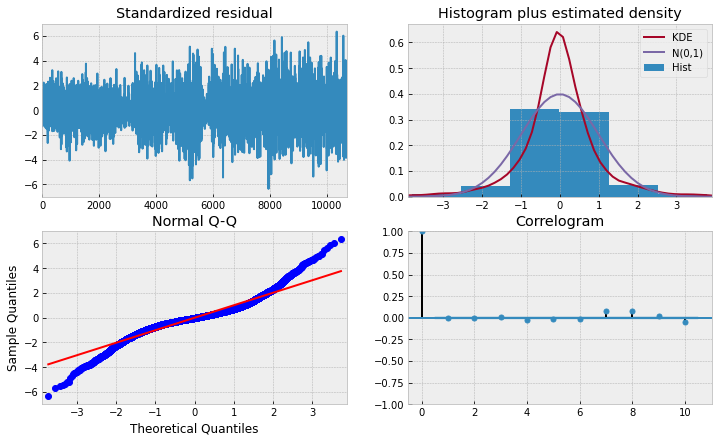

In [66]:
# plotting the residuals and checking if they meet the i.i.d requirements
_ = results.plot_diagnostics(figsize=(12, 7))

In [69]:
# Predictions on test set. Predicting only the 1st week of the test set
pred = results.get_forecast(steps = 8*7, exog = X_test_fourier.iloc[:56, :])
pred_ci = pred.conf_int()
y_actual = y_test_fourier.iloc[:8*7]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [70]:
pred2 = pd.Series(pred.predicted_mean.values, index=y_actual.index)
pred_ci2 = pd.DataFrame(pred_ci.values, index = pred2.index, columns = ['lower', 'upper'])

lower_limits = pred_ci2.loc[:,'lower']
upper_limits = pred_ci2.loc[:,'upper']


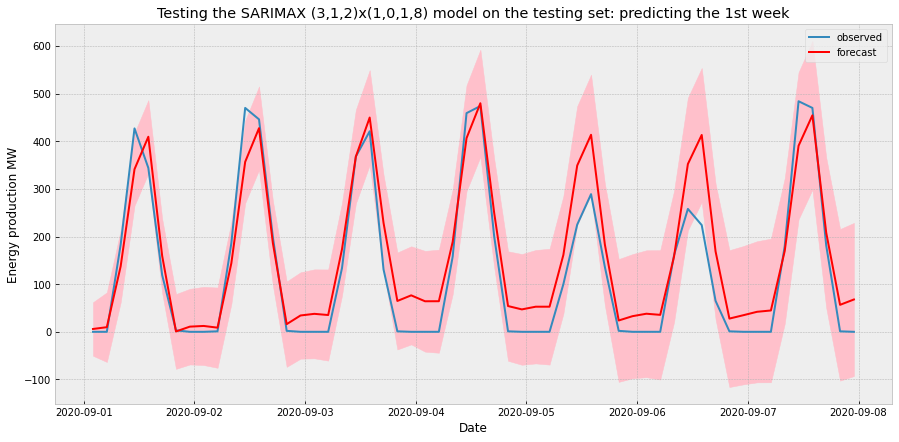

In [71]:
# plot the predictions
plt.figure(figsize = (15,7))
_ = plt.plot(y_actual.index, y_actual, label='observed')

# plot your mean predictions
_ = plt.plot(pred2.index, pred2.values, color='r', label='forecast')

# shade the area between your confidence limits
_ = plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the SARIMAX (3,1,2)x(1,0,1,8) model on the testing set: predicting the 1st week')

In [72]:
error_metrics(pred2, y_actual, 'SARIMAX(3,1,2)x(1,0,1,8) with Fourier terms 1 week')


Error metrics for model SARIMAX(3,1,2)x(1,0,1,8) with Fourier terms 1 week
RMSE or Root mean squared error: 60.00
Variance score: 0.87
Mean Absolute Error: 47.60
Mean Absolute Percentage Error: inf %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning:

divide by zero encountered in true_divide



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



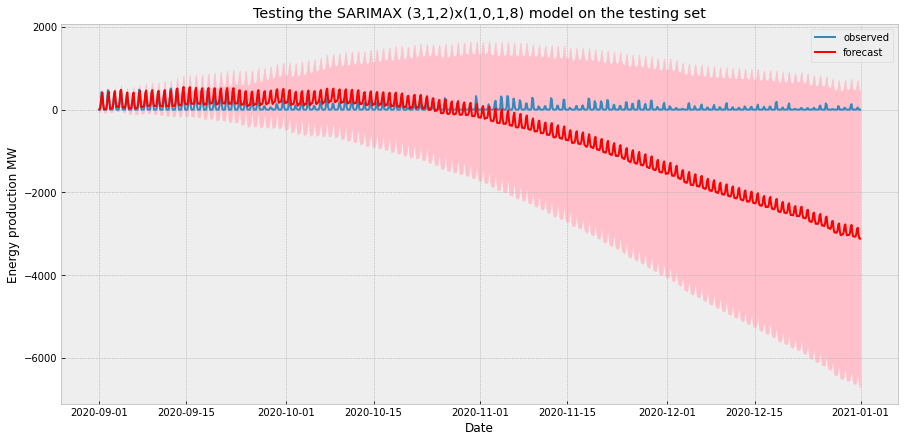

In [73]:
pred_test = results.get_forecast(steps = len(y_test_fourier), exog = X_test_fourier)
pred_ci_test = pred_test.conf_int()
y_actual = y_test_fourier

pred_test = pd.Series(pred_test.predicted_mean.values, index=y_actual.index)
pred_ci_test = pd.DataFrame(pred_ci_test.values, index = pred_test.index, columns = ['lower', 'upper'])

lower_limits = pred_ci_test.loc[:,'lower']
upper_limits = pred_ci_test.loc[:,'upper']

# plot the predictions
plt.figure(figsize = (15,7))
_ = plt.plot(y_actual.index, y_actual, label='observed')

# plot your mean predictions
_ = plt.plot(pred_test.index, pred_test.values, color='r', label='forecast')

# shade the area between your confidence limits
_ = plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the SARIMAX (3,1,2)x(1,0,1,8) model on the testing set')

In [74]:
error_metrics(pred_test, y_actual, 'SARIMAX(3,1,2)x(1,0,1,8) with Fourier terms over the test period')


Error metrics for model SARIMAX(3,1,2)x(1,0,1,8) with Fourier terms over the test period
RMSE or Root mean squared error: 1257.34
Variance score: -139.47
Mean Absolute Error: 836.84
Mean Absolute Percentage Error: inf %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning:

divide by zero encountered in true_divide



We see that the first week forecast is relatively well but afterwards the forecasting performance decreases with negative values from November onwards, and the confidence interval values grow larger. Thus, SARIMAX model was not able to capture long term trends but it did well on 1 week ahead forecast.
SARIMA models don't capture multiple seasonalities well and are also very time consuming. So, it won't be the first choice if we need both a quick and accurate forecast.